<h2>KNN Image Classification with OpenCV

We will be classifying cat and dog images using <code>OpenCV</code>.


<ul>
    <li>This file contains the following sections:
        <ul>
            <li>Import Libraries</li>
            <li>Load Images in Python</li>
            <li>Plotting an Image </li>
            <li>Gray Scale Images </li>
            <li>k-NN for Image classification </li>
        </ul>
    </li>
    
</ul>

----


## Load Important Libraries


Libraries for data processing and visualization:


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Libraries for image pre-processing and classification:


In [2]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Library for OS


In [3]:
import os

## Download Images and Annotations


Now, let's initialize and download the images.


In [5]:
import os

dataset_path = "/kaggle/input/cat-dog-images-for-classification/cat_dog/"

# List all subdirectories and files
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    # for file in files:
        # print(f"  File: {os.path.join(root, file)}")

Directory: /kaggle/input/cat-dog-images-for-classification/cat_dog/


In [6]:
import pandas as pd

# Load annotations
annotations_path = "/kaggle/input/cat-dog-images-for-classification/cat_dog.csv"
annotations = pd.read_csv(annotations_path)
print(annotations.head())


# Load and Plot and Image
We will train and classify the images using the k-NN classifier using the <code>OpenCV</code> library. 

We will pick random images and take a look:


In [8]:
annotations.columns = ["image_path", "labels"]

In [9]:
# random_filename = 'images/' + random.choice(list(annotations["annotations"].keys()))
import random

# Select a random image file path from the 'image_path' column
random_filename = random.choice(annotations["image_path"].tolist())

print("Randomly selected image:", random_filename)

Randomly selected image: cat.11760.jpg


Plot, read and show a random image using the `cv2.imread` and the `matplotlib` library.

We will also change the color space to `RGB` so we can plot it since `OpenCV` reads images as `BGR`. Early developers at `OpenCV` chose `BGR` color format because it was the format that was popular among camera manufacturers and software providers.


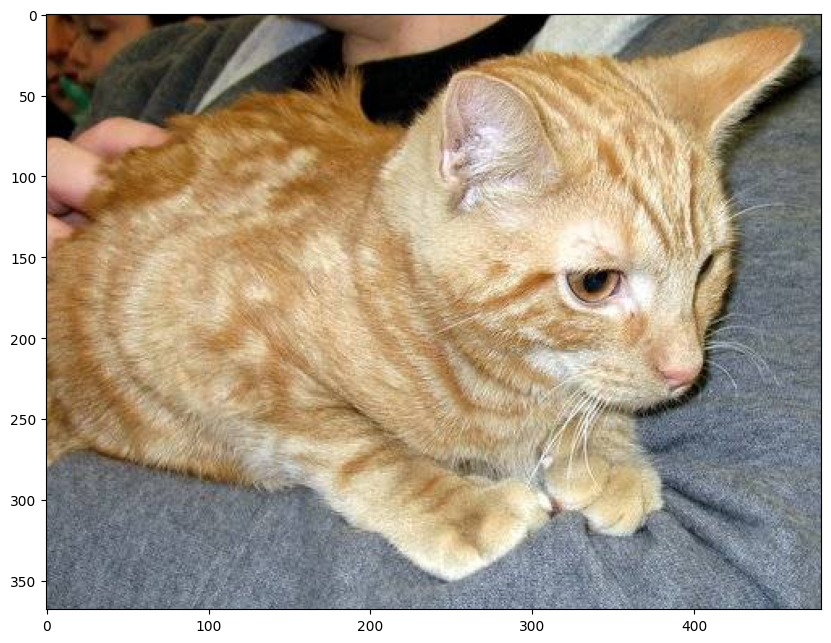

In [10]:
random_filename = os.path.join("/kaggle/input/cat-dog-images-for-classification/cat_dog/", random_filename)

sample_image = cv2.imread(random_filename)
## Convert to RGB
image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
## Now plot the image
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = "gray")
plt.show()

In [11]:
sample_image.shape

(368, 479, 3)

To perform KNN on the dataset, we will need to process the data. A smaple image will be used to explain each line of code.


Convert image to grayscale - grayscale simplifies the algorithm and reduces computational requirements.


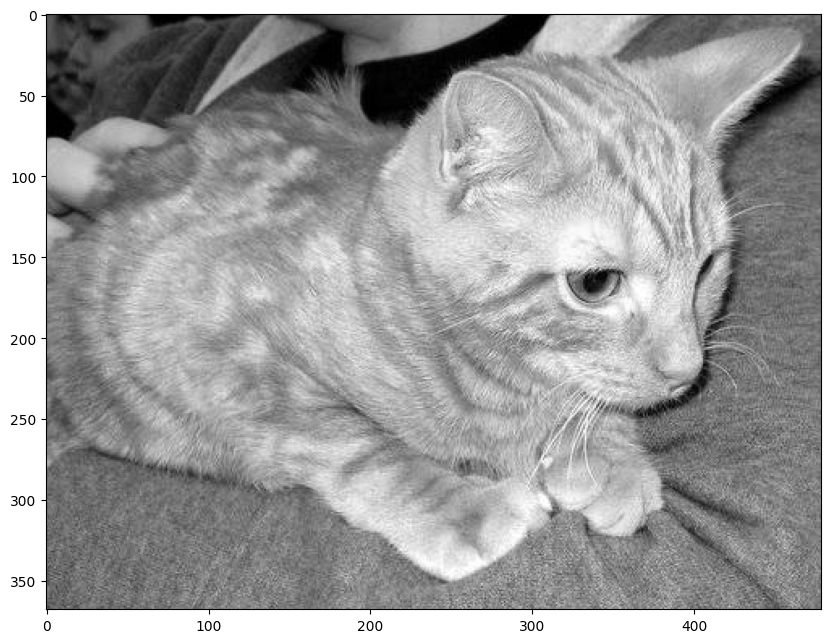

In [13]:
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(sample_image, cmap = "gray")
plt.show()

Resize image - resizing image helps the algorithm train faster.


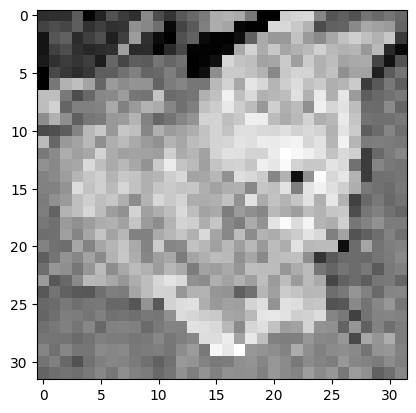

In [14]:
sample_image = cv2.resize(sample_image, (32,32))
plt.imshow(sample_image, cmap = "gray")
plt.show()

Flatten image - makes the image a numpy array for the algorithm to handle and recognize.


In [15]:
pixels = sample_image.flatten()
pixels

array([ 46,  47,  49, ...,  96, 109, 132], dtype=uint8)

## Repeat the Process Above for All Images


We will now repeat the same process above to load and process all the images. KNN is supervised machine learning algorithm, therefore we have to explicitly create labels for the machine.

In [19]:
# import os
# import cv2
# import pandas as pd
# from imutils import paths

# Load the CSV annotations
csv_path = "/kaggle/input/cat-dog-images-for-classification/cat_dog.csv"
annotations = pd.read_csv(csv_path)

# Get image paths correctly
image_paths = list(paths.list_images("/kaggle/input/cat-dog-images-for-classification/cat_dog"))
print("Total images found:", len(image_paths))

train_images = []
train_labels = []

# Loop over the input images
for (i, image_path) in enumerate(image_paths):
    image_filename = os.path.basename(image_path)  # Get just the filename

    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print("Warning: Could not read", image_filename)
        continue  # Skip this image if it fails to load

    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Retrieve label from CSV
    label_row = annotations.loc[annotations['image'] == image_filename, 'labels']
    
    if label_row.empty:
        print("Warning: No annotation found for", image_filename)
        continue  # Skip this image if no label is found

    label = int(label_row.values[0])  # Convert label to int
    tmp_label = "cat" if label == 0 else "dog"

    # Resize image
    image = cv2.resize(image, (32, 32))

    # Flatten the image
    pixels = image.flatten()

    # Append data
    train_images.append(pixels)
    train_labels.append(label)

    # print('Loaded...', 'Image', str(i+1), 'is a', tmp_label)

print("Finished loading dataset")

Total images found: 25000
Finished loading dataset


Create an array of the <code>train_images</code> and <code>train_labels</code>. <code>OpenCV</code> only identifies arrays of type <code>float32</code> for the training samples and array of shape <code>(label size, 1)</code> for the training labels. We can do that by specifying <code>astype('float32')</code> on the numpy array of the training samples and convert the training labels to integers and <code>reshape</code> the array to <code>(label size, 1)</code>. When you print the <code>train_labels</code>, the array will look like this <code>[[1], [0], ..., [0]]</code></p>


In [20]:
train_images = np.array(train_images).astype('float32')
train_labels = np.array(train_labels)

In [21]:
train_labels = train_labels.astype(int)
train_labels = train_labels.reshape((train_labels.size,1))
print(train_labels)

[[0]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


Split data into training and test set with a test size of your choice:


In [22]:
test_size = 0.2
train_samples, test_samples, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=test_size, random_state=0)

To train the KNN model, we will use the <code>cv2.ml.KNearest_create()</code> from the <code>OpenCV</code> library. We need to define how many nearest neighbors will be used for classification as a hyper-parameter k. This parameter k can be toggled with/tuned in the training or model validation process. Fit the training and test images and get the accuracy score of the model.

We will try multiple values of <code>k</code> to find the optimal value for the dataset we have. <code>k</code> refers to the number of nearest neighbours to include in the majority of the voting process.

In [23]:
start_datetime = datetime.now()

knn = cv2.ml.KNearest_create()
knn.train(train_samples, cv2.ml.ROW_SAMPLE, train_labels)

## get different values of K
k_values = [1, 2, 3, 4, 5]
k_result = []
for k in k_values:
    ret,result,neighbours,dist = knn.findNearest(test_samples,k=k)
    k_result.append(result)
flattened = []
for res in k_result:
    flat_result = [item for sublist in res for item in sublist]
    flattened.append(flat_result)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Training Duration: 0:01:44.449118


We will get the accuracy value for each value of <code>k</code> i.e., how many percent of the images were classified correctly? We will create a confusion matrix for a more comprehensive classification model evaluation.


In [24]:
## create an empty list to save accuracy and the cofusion matrix
accuracy_res = []
con_matrix = []
## we will use a loop because we have multiple value of k
for k_res in k_result:
    label_names = [0, 1]
    cmx = confusion_matrix(test_labels, k_res, labels=label_names)
    con_matrix.append(cmx)
    ## get values for when we predict accurately
    matches = k_res==test_labels
    correct = np.count_nonzero(matches)
    ## calculate accuracy
    accuracy = correct*100.0/result.size
    accuracy_res.append(accuracy)
## stor accuracy for later when we create the graph
res_accuracy = {k_values[i]: accuracy_res[i] for i in range(len(k_values))}
list_res = sorted(res_accuracy.items())

**A Quick Guide to the Confusion Matrix**


A confusion matrix is a performance measurement for classification problem. It is a table with a combination of predicted and actual values. On the y-axis, we have the `True` label and on the x-axis we have the `Predicted` label. This example will focus on a binary classifier, i.e. a yes or no model.


When we talk about confusion matrix, we talk about a few terms:
* True Positive (TP): Our model predicted "yes", and it was actually "yes"
* True Negative (TN): Our model predicted "no", and it was actually "no"
* False Positive (FP): Our model predicted "yes", but it was actually "no"
* False Negative (FN): Our model predicted "no", but it was actually "yes"

Let's look at an example:

<table>
  <tr>
    <td>&nbsp;</td>
    <td>Predicted: NO</td>
    <td>Predicted: YES</td>
  </tr>
  <tr>
    <td>True: NO</td>
    <td>TN = 30</td>
    <td>FP = 30</td>
    <td>60</td>
  </tr>
  <tr>
    <td>True: YES</td>
    <td>FN = 10</td>
    <td>TP = 50</td>
    <td>60</td>
  </tr>
  <tr>
    <td>&nbsp;</td>
    <td>40</td>
    <td>80</td>
  </tr>
</table>

**Accuracy** is the number the model got right over the total number of predictions. This is (TP+TN)/Total Number of Oredictions.


Now let's visualize the confusion matrix:


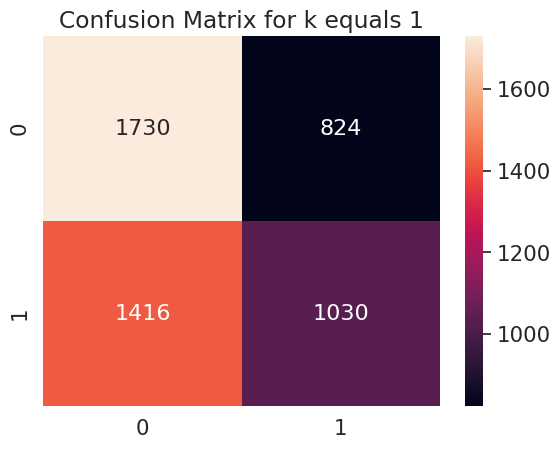

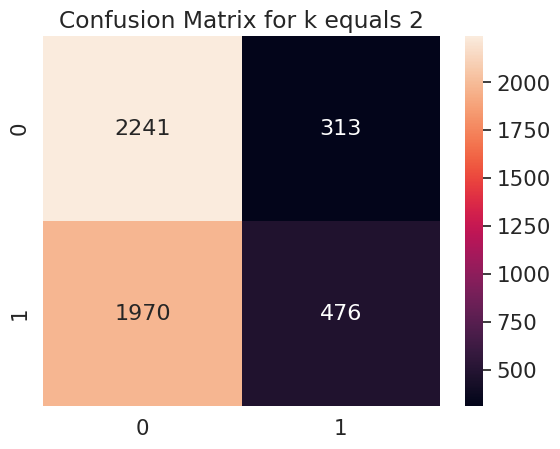

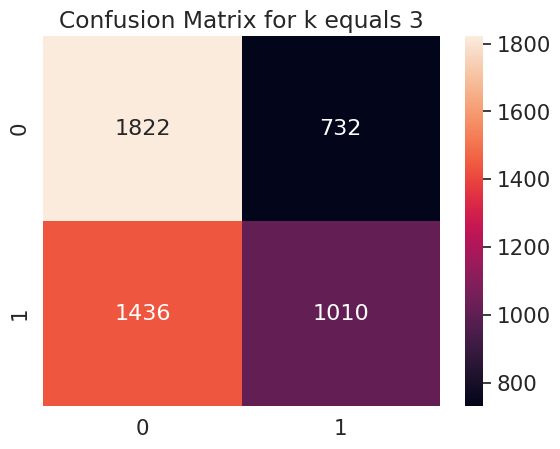

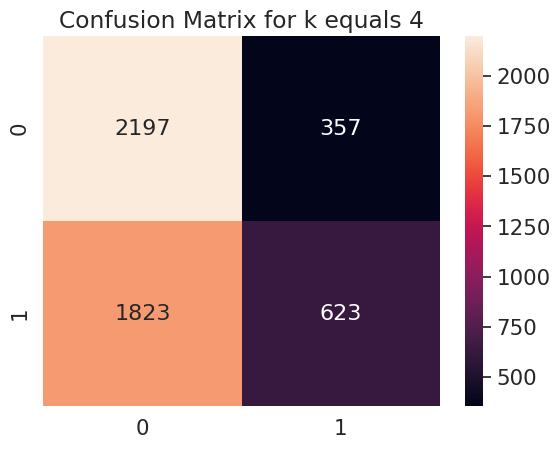

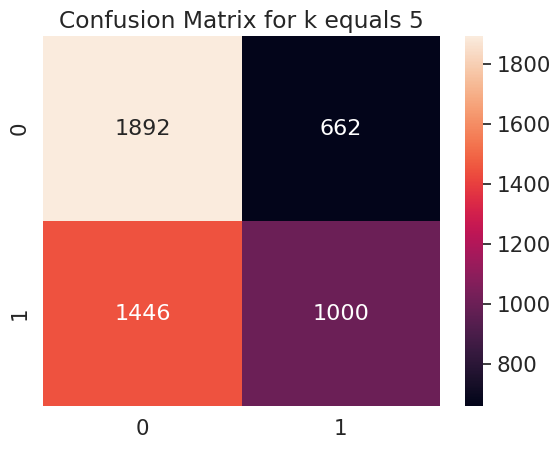

In [25]:
t=0
## for each value of k we will create a confusion matrix
for array in con_matrix:
    df_cm = pd.DataFrame(array)
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt = ".0f") # font size
    t += 1
    title = "Confusion Matrix for k equals " + str(t)
    plt.title(title)
    plt.show()


We will plot the accuracy to see which one is highest i.e., what percentage of images were classified correctly?


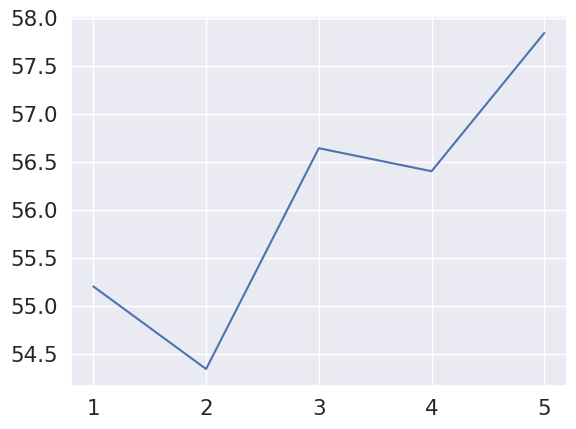

In [26]:
## plot accuracy against 
x, y = zip(*list_res)
plt.plot(x, y)
plt.show()

We will get the best value of <code>k</code> to train the model to test the model on our image:


In [27]:
k_best = max(list_res,key=lambda item:item[1])[0]
k_best

5